In [1]:
import numpy as np
import pandas as pd
import datetime
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt

In [2]:
주가 = pd.read_csv("..\\..\\data\\daily_price.csv", encoding = "ms949")

financial_quarter = pd.read_csv("..\\..\\code\\데이터 전처리\\quarter_filter.csv", encoding = "ms949", index_col = ["Symbol", "date"])
financial_year = pd.read_csv("..\\..\\code\\데이터 전처리\\year_filter.csv", encoding = "ms949", index_col = ["Symbol", "date"])
stock_daily = pd.read_csv("..\\..\\code\\데이터 전처리\\daily_stock_filter.csv", encoding = "ms949", index_col = ["Symbol", "date"])

C:\Users\punk\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (1842,1843,1844,1845,1846,1847,1848,1849,1850,1851,1852,1853,1854,1855,1856,1857,1858,1859,1860,1861,1862,1863,1864,1865) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
주가 = 주가.drop("Item Name ", axis = 1)
주가 = 주가.set_index("Symbol")
시간변환 = pd.to_datetime(주가.columns)
시간변환 = 시간변환.rename("date")
주가.columns = 시간변환

for 시간 in 주가.columns:
    주가[시간] = 주가[시간].str.replace(',', "")

주가 = 주가.astype(float)
주가 = 주가.transpose()

In [4]:
financial_year = financial_year.reset_index().set_index(["date", "Symbol"])
financial_quarter = financial_quarter.reset_index().set_index(["date", "Symbol"])
stock_daily = stock_daily.reset_index().set_index(["date", "Symbol"]).sort_index()

In [5]:
def assign_year(date):
    date = datetime.datetime.strptime(date, "%Y-%m-%d")
    year = date.year
    month = date.month
    
    if month > 3:
        ref_year = year - 1
        
    else:
        ref_year = year - 2
        
    return (ref_year)
        

In [6]:
def assign_quarter(date):
    date = datetime.datetime.strptime(date, "%Y-%m-%d")
    year = date.year
    month = date.month
    day = date.day
    
    if month > 3:
        if month == 4:
            ref_year = year - 1
            ref_month = "12"
            
        elif month == 5:
            if day > 15:
                ref_year = year
                ref_month = "03"
            else:
                ref_year = year - 1
                ref_month = "12"
                
        elif (month == 6) or (month == 7):
            ref_year = year
            ref_month = "03"
            
        elif month == 8 :
            if day > 15:
                ref_month = "06"
            else:
                ref_month = "03"
            ref_year = year
            
        elif (month == 9) or (month == 10):
            ref_year = year
            ref_month = "06"
            
        elif month == 11:
            if day > 15:
                ref_month = "09"
                
            else:
                ref_month = "06"
            ref_year = year
                
        elif month == 12:
            ref_year = year
            ref_month = "09"
        
        
    else:
        ref_year = year - 1
        ref_month = "09"
        
    return str(ref_year) + "-" +ref_month
        

## 여러조건들 중 조건 아래와 같은 조건들이 선택되었다고 가정

In [7]:
연도재무선택조건 = ["매출액 100억 이상", "영업이익 3년동안 0 이상", 
                        "부채비율 150% 이하", "배당존재", "ROE 5퍼 이상", 
                        "3년 중 2년 이상 투자활동으로인한현금흐름 0 미만","3년 중 2년 이상 영업활동으로인한현금흐름 0 초과", 
                        "이익잉여금이 3년동안 증가", "영업이익률 3년동안 증가", "자본금 변동없음", "배당이 3년동안 증가" ]

분기재무선택조건 = ["영업이익 4개분기 0 이상", "매출액 전년도 동기 대비 증가"]

일별주식선택조건 = ["20일 평균거래량 20억 이하", "10거래일 10% 이하 상승", "40거래일 50% 이하 상승", "90거래일 최저가 영역"]

### 각각 해당하는 조건 데이터프레임에서 조건들을 만족하는 모든 회사들을 뽑아온다

In [8]:
연도조건만족회사 = financial_year[연도재무선택조건][financial_year[연도재무선택조건].sum(axis = 1) == len(연도재무선택조건)]
분기조건만족회사 = financial_quarter[분기재무선택조건][financial_quarter[분기재무선택조건].sum(axis = 1) == len(분기재무선택조건)]
일별조건만족회사 = stock_daily[일별주식선택조건][stock_daily[일별주식선택조건].sum(axis = 1) == len(일별주식선택조건)]

## 입력으로 받는 인자들

In [ ]:
## 추후 리밸런싱을 일단위로 하지 않고 월단위로 할경우!
## 상장폐지된 기업들 어떻게 처리할건지

In [9]:
invest_start_day = "2018-04-29"
invest_end_day = "2019-02-01"
rebalancing_freq = "30d"

# ----------------------------------------------------------------------------------------

In [10]:
rebalancing_day = pd.date_range(invest_start_day, invest_end_day, freq=rebalancing_freq)

In [11]:
rebalancing_day

DatetimeIndex(['2018-04-29', '2018-05-29', '2018-06-28', '2018-07-28',
               '2018-08-27', '2018-09-26', '2018-10-26', '2018-11-25',
               '2018-12-25', '2019-01-24'],
              dtype='datetime64[ns]', freq='30D')

In [12]:
assign_year(invest_start_day)

2017

In [13]:
assign_quarter(invest_start_day)

'2017-12'

In [14]:
def 해당시점조건만족회사추출(시점):
    시점 = 시점.strftime("%Y-%m-%d")
    해당시점연도조건충족하는회사들 = 연도조건만족회사.loc[assign_year(시점)].index
    해당시점분기조건충족하는회사들 = 분기조건만족회사.loc[assign_quarter(시점)].index
    해당시점일별조건충족하는회사들 = 일별조건만족회사.loc[시점].index
    
    모든회사 = 해당시점연도조건충족하는회사들.tolist() + 해당시점분기조건충족하는회사들.tolist() + 해당시점연도조건충족하는회사들.tolist()
    모든조건충족회사 = list(set([x for x in 모든회사 if 모든회사.count(x) == 3]))
    return 모든조건충족회사

In [102]:
수익률 = pd.DataFrame()
회사개수 = pd.DataFrame()
last_portfolio = 100
for day in rebalancing_day:
    rebalancing_freq_int = int(rebalancing_freq[:-1])
    조건만족회사 =  해당시점조건만족회사추출(day)

    start_time = day
    end_time = start_time + relativedelta(days = rebalancing_freq_int)
    A = 주가[start_time:end_time][조건만족회사]
    
    
    B = (A - A.shift(1) )/ A.shift(1)
    B = B + 1
    B = B.fillna(last_portfolio)
    B = B.cumprod().mean(axis = 1)
    last_portfolio = B[-1]
    B = pd.DataFrame(B, columns = ["포트폴리오가치"])
    
    
    포트폴리오개수 = A.count(axis = 1)
    포트폴리오개수 = pd.DataFrame(포트폴리오개수, columns = ["회사개수"])
    회사개수 = pd.concat([회사개수, 포트폴리오개수])
    

    수익률 = pd.concat([수익률, B])
    

In [107]:
최종 = pd.concat([수익률, 회사개수], axis = 1)

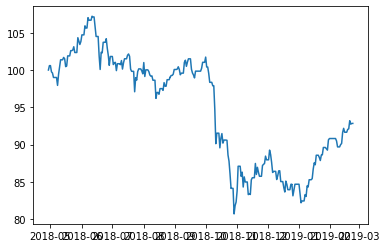

In [108]:
plt.plot(최종["포트폴리오가치"])